# ML for breathing - copy based on sci-kit learn 1.1.1

Applying simple, common machine learning models to segments of EMG to predict whether segment was with our without respiratory muscle effort i.e. whether we are looking at a patient created breath.

## Import libraries

In [1]:
#basic ds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#basic system
import sys
import os
import glob


# math and signals
import math
from scipy.stats import entropy
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
# demo stuff
import ipywidgets as widgets
import seaborn 

In [2]:
# ml stuff
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.metrics import confusion_matrix
import joblib

In [3]:
# our stuff
from resurfemg.config import Config
sys.path.insert(0, '../resurfemg')
import helper_functions as hf

In [4]:
# get new changes in our library i.e. the tmsisdk

sys.path.insert(0, '../resurfemg')

from tmsisdk_lite import Poly5Reader

C:\Users\makeda\anaconda3\envs\emgandash\lib\site-packages\mne\fixes.py:321: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(scipy.__version__) >= '1.1':
C:\Users\makeda\anaconda3\envs\emgandash\lib\site-packages\mne\fixes.py:1134: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(numba.__version__) < LooseVersion('0.40'):
C:\Users\makeda\anaconda3\envs\emgandash\lib\site-packages\mne\fixes.py:1134: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(numba.__version__) < LooseVersion('0.40'):


## Import and set up data ( see ML_snippet_maker notebook for generation)

In [5]:

csv = pd.read_csv('../researcher_interface/ML_files/for_ml_csv.csv')
csv2 = pd.read_csv('../researcher_interface/ML_files/for_ml_csv2.csv')

In [6]:
csv2.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,991,992,993,994,995,996,997,998,999,label
0,0,0.000059,0.000055,0.000044,0.000039,0.000170,0.000218,0.000110,0.000061,0.000186,...,0.000021,0.000042,5.928041e-05,0.000069,0.000038,0.000040,0.000102,1.012105e-04,0.000054,exhale
1,1,0.000184,0.000016,0.000167,0.000237,0.000167,0.000027,0.000084,0.000080,0.000046,...,0.000036,0.000035,6.349561e-05,0.000040,0.000021,0.000079,0.000079,2.753498e-05,0.000024,exhale
2,2,0.000040,0.000155,0.000183,0.000081,0.000122,0.000079,0.000111,0.000013,0.000076,...,0.000104,0.000251,2.212753e-04,0.000087,0.000023,0.000048,0.000020,2.833529e-07,0.000018,exhale
3,3,0.000130,0.000068,0.000023,0.000010,0.000072,0.000043,0.000043,0.000044,0.000068,...,0.000092,0.000077,4.719800e-08,0.000100,0.000139,0.000062,0.000064,1.051652e-04,0.000033,exhale
4,4,0.000212,0.000112,0.000047,0.000122,0.000386,0.000544,0.000385,0.000042,0.000408,...,0.000039,0.000111,7.080898e-05,0.000034,0.000106,0.000104,0.000042,3.894382e-05,0.000074,exhale


In [7]:
csv = csv.dropna()
csv2 = csv2.dropna()

In [8]:
#len(csv2)

In [9]:
listicle = (list(range(999)))
fu = list(map(str, listicle))

We are going to add some random values for sanity checking... ML based on random values should give us an accuracy approaching 0.5 in this case.

In [10]:
csv2['std'] = csv2[fu].std(axis=1)
csv2['max'] = csv2[fu].max(axis=1)
csv2['min'] = csv2[fu].min(axis=1)
csv2['mean'] = csv2[fu].mean(axis=1)
csv2['entropy'] = csv2[fu].apply(entropy, axis=1)
csv2['random1'] = csv2.apply(lambda x: np.random.randint(0,100-x['1'],1)[0], axis=1)
csv2['random2'] = csv2.apply(lambda x: np.random.randint(0,100-x['2'],1)[0], axis=1)


In [11]:
csv['std'] = csv[fu].std(axis=1)
csv['max'] = csv[fu].max(axis=1)
csv['min'] = csv[fu].min(axis=1)
csv['mean'] = csv[fu].mean(axis=1)
csv['entropy'] = csv[fu].apply(entropy, axis =1)
csv['random1'] = csv.apply(lambda x: np.random.randint(0,100-x['1'],1)[0], axis=1)
csv['random2'] = csv.apply(lambda x: np.random.randint(0,100-x['2'],1)[0], axis=1)

In [12]:
csv.loc[csv['label']== 'exhale', 'label'] = 0
csv.loc[csv['label']== 'inhale', 'label'] = 1
csv2.loc[csv2['label']== 'exhale', 'label'] = 0
csv2.loc[csv2['label']== 'inhale', 'label'] = 1

In [13]:
csv_to = pd.concat([csv,csv2])

Now we have a data frame of the raw data (columns 0:999) from a bunch of EMG snippets (the rows) , and some features of them e.g. maximum value, mean etc.

In [14]:
len(csv_to)

161

In [15]:
csv_to.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,998,999,label,std,max,min,mean,entropy,random1,random2
0,0,0.000293,0.000044,0.000122,0.000150,0.000100,0.000021,0.000029,0.000008,0.000071,...,0.000172,0.000157,0,0.000107,0.000877,3.489493e-08,0.000121,6.562215,36,63
1,1,0.000560,0.000973,0.000416,0.000651,0.000581,0.000960,0.000160,0.000542,0.000718,...,0.000046,0.000183,0,0.000145,0.001672,2.862469e-07,0.000149,6.534337,86,1
2,2,0.000344,0.000316,0.000068,0.000141,0.000122,0.000045,0.000160,0.000136,0.000027,...,0.000056,0.000027,0,0.000115,0.000717,1.938155e-07,0.000143,6.602710,60,82
3,3,0.000119,0.000244,0.000329,0.000255,0.000017,0.000245,0.000409,0.000384,0.000086,...,0.000312,0.000265,0,0.000145,0.001843,1.400717e-07,0.000137,6.535672,8,24
4,4,0.000148,0.000189,0.000014,0.000152,0.000111,0.000044,0.000428,0.000469,0.000009,...,0.000186,0.000350,0,0.000116,0.000747,2.365364e-07,0.000140,6.591293,48,87


# Correlations

In [16]:
loco = csv_to[['std','max', 'min', 'mean', 'entropy', 'random1', 'random2', 'label']]
#seaborn.heatmap(loco)
local = pd.DataFrame(loco)
#print(type(
local['label_int']= local['label'].astype('int')

In [17]:
#local.corr()

<AxesSubplot:>

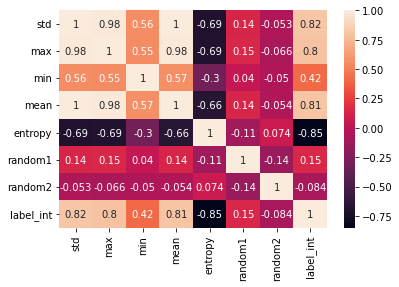

In [18]:
%matplotlib inline
seaborn.heatmap(local.corr(), annot = True)

What is important to note is that in terms of our label, nothing even comes to 90% correlation. We need a more complex model than picking breaths b.y one parameter. Hence machine learning (ML) to the rescue

## ML

You can pick more than one feature with the shift key

In [19]:
features = widgets.SelectMultiple(
    options=['std','max', 'min', 'mean', 'entropy', 'random1', 'random2'],
    value=['min'],
    #rows=10,
    description='Features',
    disabled=False
)
features

SelectMultiple(description='Features', index=(2,), options=('std', 'max', 'min', 'mean', 'entropy', 'random1',…

In [20]:
features_list = list(features.value)
features_list

['mean', 'entropy']

In [21]:
X = csv_to.drop('label', axis =1)
X = X[features_list].values
X = X.astype('float')

In [22]:
len(X)

161

In [23]:
y = csv_to['label'].values
y=y.astype('int')

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
X_train

array([[6.32953201e-05, 6.58319142e+00],
       [1.42895121e-04, 6.60270967e+00],
       [4.12587555e-04, 6.45430345e+00],
       [8.95334825e-04, 6.50132501e+00],
       [7.78987941e-04, 6.48229252e+00],
       [8.50323014e-04, 6.51291008e+00],
       [6.41521503e-05, 6.57065693e+00],
       [1.32173108e-04, 6.54072373e+00],
       [3.88028263e-04, 6.47853603e+00],
       [6.55457569e-05, 6.58152352e+00],
       [6.47798884e-05, 6.56724908e+00],
       [3.86951405e-04, 6.46904728e+00],
       [1.14033800e-03, 6.55608856e+00],
       [6.59175278e-05, 6.56603638e+00],
       [1.40988774e-04, 6.56154371e+00],
       [3.73691054e-04, 6.50276211e+00],
       [9.70317320e-04, 6.43999463e+00],
       [7.06861881e-05, 6.51396031e+00],
       [1.40109526e-04, 6.58095765e+00],
       [8.98659937e-04, 6.49736386e+00],
       [6.76178376e-05, 6.57612170e+00],
       [1.41921414e-04, 6.59546443e+00],
       [1.37070680e-04, 6.55448962e+00],
       [6.37229101e-05, 6.53290818e+00],
       [3.621328

In [27]:
np.save('x_trainer_for_scale',X_train)

In [28]:
# scale
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

In [29]:
svm = SVC(kernel= 'linear', random_state=1, C=0.1)
svm.fit(X_train, y_train)

SVC(C=0.1, kernel='linear', random_state=1)

In [30]:
y_pred = svm.predict(X_test)
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Accuracy: 1.000


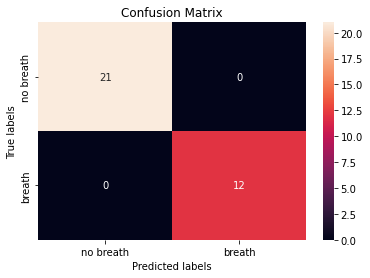

In [31]:
cm = confusion_matrix(y_test, y_pred)
ax= plt.subplot()
seaborn.heatmap(cm, annot=True, fmt='g', ax=ax);  
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['no breath', 'breath']); ax.yaxis.set_ticklabels(['no breath', 'breath']);

In [32]:
lr = LogisticRegression(solver='liblinear', random_state=0)
lr.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [33]:
y_pred = lr.predict(X_test)

In [34]:
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Accuracy: 1.000


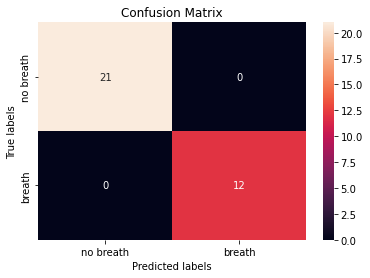

In [35]:
cm = confusion_matrix(y_test, y_pred)
ax= plt.subplot()
seaborn.heatmap(cm, annot=True, fmt='g', ax=ax);  
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['no breath', 'breath']); ax.yaxis.set_ticklabels(['no breath', 'breath']);

In [36]:
dt = tree.DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [37]:
y_pred = dt.predict(X_test)

In [38]:
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Accuracy: 1.000


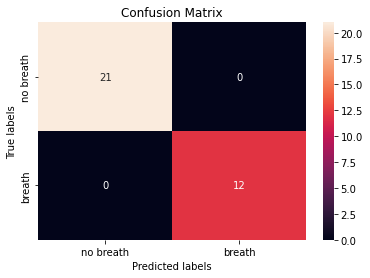

In [39]:
cm = confusion_matrix(y_test, y_pred)
ax= plt.subplot()
seaborn.heatmap(cm, annot=True, fmt='g', ax=ax);  
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['no breath', 'breath']); ax.yaxis.set_ticklabels(['no breath', 'breath']);

OK, OK, a model with only max and entropy works 100%. This makes sense. Breaths are taller and more entropic..by our definition. What we would need to do is cut the breaths by expert hand, include some edge cases, then run this ML over that (potentially different) dataset. ALso remember we only had a few features in our dataset, of about 100 samples. What we can do it add 3X on data and features, with and without entropy. Will discuss with scientists exactly what features they want.

In [ ]:
filename = '../ml_models/finalized_svm_model_in_111.sav'
joblib.dump(svm, filename)
 
# some time later...you can load the model from disk


In [ ]:
filename = '../ml_models/finalized_lr_model_in_111.sav'
joblib.dump(lr, filename)

In [ ]:
# let's explore how we might apply a model over a running emg

In [40]:
root_emg_directory = os.path.join('../not_pushed','topspin_data_anonymized')
emg_pattern = os.path.join(root_emg_directory, '**/*.Poly5')
emg_and_draeger_files = glob.glob(emg_pattern, recursive=True)

emg_files = []
draeger_files = []

for file in emg_and_draeger_files:
    if 'Draeger' in file:
        draeger_files.append(file)
    else:
        emg_files.append(file)

In [41]:
list_of_numbers_strung = []
for i in range(len(emg_files)):
    list_of_numbers_strung.append(str(i))


btn = widgets.Dropdown(
    options=list_of_numbers_strung,
    value='0',
    description='Picked File:',
    disabled=False,
)
display(btn)

Dropdown(description='Picked File:', options=('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '1…

In [42]:
number_chosen = int(btn.value)
file_chosen = emg_files[number_chosen] 
print("The file you chose is:",file_chosen)

The file you chose is: ../not_pushed\topspin_data_anonymized\M001\001\EMG_recording.Poly5


In [43]:
data_emg = Poly5Reader(file_chosen)
data_samples= data_emg.samples
emg_sample_rate = data_emg.sample_rate
converted_to_seconds =  []
converted_to_samples = []
for i in range(len(data_samples[0])):
    converted_to_seconds.append(i/emg_sample_rate)
    converted_to_samples.append(i)

Reading file  ../not_pushed\topspin_data_anonymized\M001\001\EMG_recording.Poly5
	 Number of samples:  172576 
	 Number of channels:  3 
	 Sample rate: 2048 Hz
Done reading data.


In [44]:
len(data_samples[1])

172576

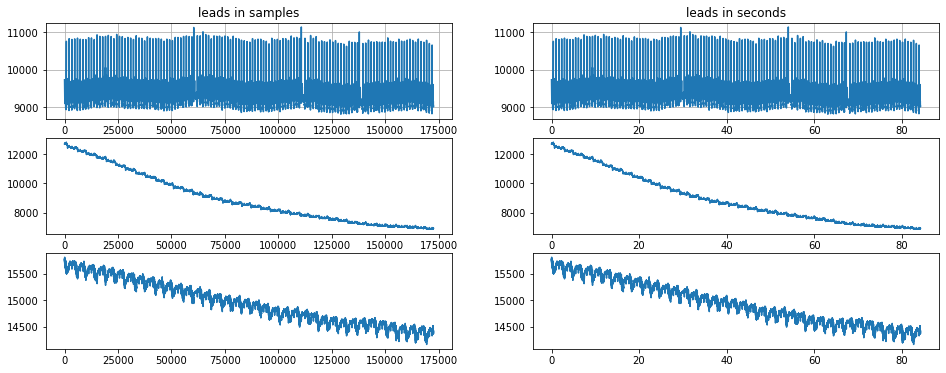

In [45]:
%matplotlib inline
# set up plotn
x = data_samples[:20000]
fig, axis = plt.subplots(nrows = 3, ncols = 2, figsize=(16, 6))
#ax.set_ylim([-4, 4])
axis[0,0].grid(True)
axis[0,0].plot(x[0])
axis[0,0].set(title='leads in samples')
axis[1,0].plot(x[1])
axis[2,0].plot(x[2])
axis[0,1].set(title='leads in seconds')
axis[0,1].grid(True)
axis[0,1].plot(converted_to_seconds,x[0])
axis[1,1].plot(converted_to_seconds,x[1])
axis[2,1].plot(converted_to_seconds,x[2])

In [46]:
alt_emg_processed = hf.working_pipeline_pre_ml(data_samples, 'peaks')

C:\Users\makeda\anaconda3\envs\emgandash\lib\site-packages\sklearn\decomposition\_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(


In [47]:
emg_processed = hf.working_pipeline_pre_ml(data_samples, 'heart')

C:\Users\makeda\anaconda3\envs\emgandash\lib\site-packages\sklearn\decomposition\_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(


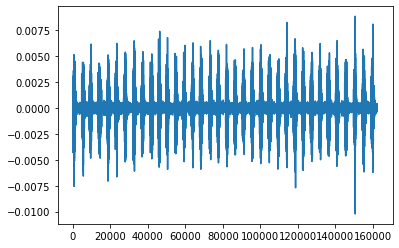

In [48]:
plt.plot(emg_processed)

In [49]:
# we had a final step in the snippet maker to make everything positive
our_emg_processed = abs(emg_processed)

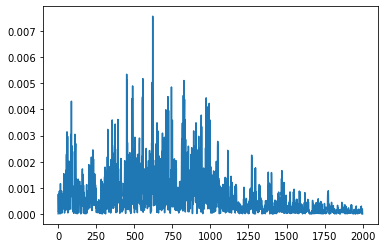

In [50]:
plt.plot(our_emg_processed[:2000])
plt.show()

In [51]:
#toy_list = list(range(1,10000))
#toy_array = np.array(toy_list)
toy_array = our_emg_processed[:80000]
index_ml_hold = []
predictions_made = []
holder = []
for slice in hf.slices_jump_slider(toy_array, 1000,1):
    ml_index_feature1 = slice.mean() #close to mean
    ml_index_feature2 = entropy(slice)
    holder.append(slice)
    ml_index_test= [ml_index_feature1, ml_index_feature2]

    index_ml_hold.append(ml_index_test)
#     # need to reshape array
X_test_live = index_ml_hold
X_test_live = sc.transform(X_test_live)
predictions_svm = svm.predict(X_test_live)
predictions_lr = lr.predict(X_test_live)
    #predictions_made.append(predictions)


In [52]:
len(index_ml_hold)

79000

In [53]:
predictions_lr

array([1, 1, 1, ..., 0, 0, 0])

In [54]:
sum(predictions_svm)

43151

In [55]:
sum(predictions_lr)

43126

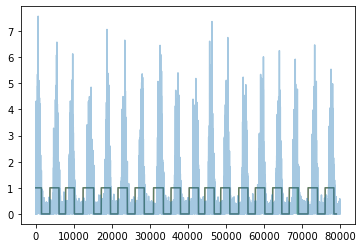

In [56]:
plt.plot(predictions_svm, color='purple', alpha= 0.5)
plt.plot(predictions_lr, color='green',  alpha= 0.5)
plt.plot(toy_array*1000, alpha=0.4)

Remember at each point it looks 1000 forward, and makes a prediciton over the whole array, this we should probably shift the prediction arrays forward by 500

In [57]:
shifter = np.zeros(500) +3


In [ ]:
shifted_lr = np.hstack((shifter, predictions_lr))
shifted_svm = np.hstack((shifter, predictions_svm)) 

In [ ]:
plt.plot(shifted_svm, color='purple', alpha= 0.5)
plt.plot(shifted_lr, color='green',  alpha= 0.5)
plt.plot(toy_array*1000, alpha=0.4)

Perfect predictions? Let's try more cases, and see how our models do.

In [ ]:
150000/2048